In [ ]:
from pathlib import Path
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import sys
repo_path = Path(r"C:\Users\everett\Documents\GitHub")  # Replace with the actual path to the optswmm repository
sys.path.append(str(repo_path))
from camus_to.src.performance import Performance



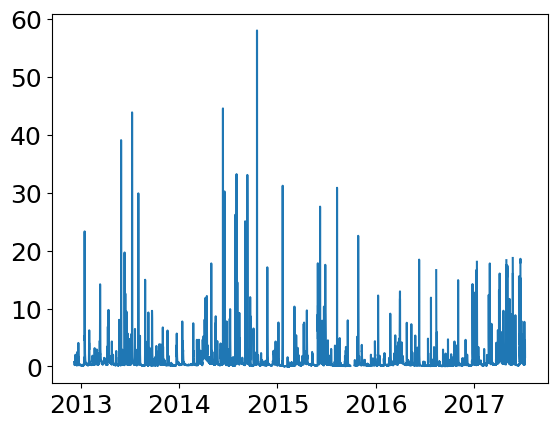

In [478]:

model_dir = base_dir / "HY017"


forcings = pd.read_pickle(model_dir / "forcings.pkl")

targets = pd.read_pickle(model_dir / "targets.pkl")

plt.plot(targets["discharge(cms)"])


In [483]:
for model in [["HY017"]]:
    

    model_dir = base_dir / model

TypeError: unsupported operand type(s) for /: 'WindowsPath' and 'list'

In [485]:

base_dir = Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm")
for model in ["HY017"]:#:base_dir.iterdir():
    

    model_dir = base_dir / model

    if not (model_dir / "sim_val.pkl").exists():
        continue
    model_dir = base_dir / model


    forcings = pd.read_pickle(model_dir / "forcings.pkl")

    targets = pd.read_pickle(model_dir / "targets.pkl")

    swmm = pd.read_pickle(model_dir / "sim_val.pkl")
    swmm_target = pd.read_pickle(model_dir / "obs_val.pkl")
    target = swmm - swmm_target


    discharge = targets["discharge(cms)"].shift(6)

    #forcings.dropna(inplace=True)


    data = pd.concat([discharge, forcings], axis=1)


    common_dti = data.index.intersection(target.index)
    data = np.array(data.loc[common_dti])
    target = np.array(target.loc[common_dti])
    swmm = swmm.loc[common_dti]

    # Preprocessing
    seq_len = 24

    # Apply Z-normalization
    data_mean = np.nanmean(data, axis=0)
    data_std = np.nanstd(data, axis=0)
    data_scaled = (data - data_mean) / data_std

    target_mean = np.nanmean(target, axis=0)
    target_std = np.nanstd(target, axis=0)
    target_scaled = (target - target_mean) / target_std

    X, y = [], []
    for i in range(len(data_scaled) - seq_len):
        X.append(data_scaled[i:i + seq_len])
        y.append(target_scaled[i + seq_len])

    X, y = np.array(X), np.array(y)

    valid_indices = ~np.isnan(X).any(axis=(1, 2)) & ~np.isnan(y).any(axis=1)
    X = X[valid_indices]
    y = y[valid_indices]

    # Train/Test/Validation Split
    train_size = int(0.5 * len(X))
    val_size = int(0.1 * len(X))
    test_size = len(X) - train_size - val_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Model
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(seq_len, X.shape[2])),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Training
    history = model.fit(X_train, y_train, epochs=96, batch_size=64, validation_data=(X_val, y_val))
    # Record training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Save the training history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(model_dir / "training_history.csv", index=False)


    # Evaluate the model on training and testing datasets
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    # Get predictions for the test dataset
    y_pred = model.predict(X)

    y_pred = y_pred * target_std + target_mean


    swmm_corrected = swmm[:-seq_len][valid_indices] - y_pred
    swmm_corrected = swmm_corrected[swmm_corrected > 0][:train_size]
    swmm_uncorrected = swmm[:-seq_len][valid_indices][:train_size]
    obs = swmm_target[:-seq_len][valid_indices][:train_size]

    perf_swmm = Performance(obs, swmm_uncorrected)
    perf_swmm_corrected = Performance(obs, swmm_corrected)

    perf_swmm_corrected.kge()
    perf_swmm.kge()

    merged = pd.concat([swmm_corrected, swmm_uncorrected, obs], axis=1, keys=["Corrected", "Uncorrected", "Observed"])
    merged.to_csv(model_dir / "timeseries_corrected_train.csv")


    swmm_corrected = swmm[:-seq_len][valid_indices] - y_pred
    swmm_corrected = swmm_corrected[swmm_corrected > 0][train_size + val_size:]
    swmm_uncorrected = swmm[:-seq_len][valid_indices][train_size + val_size:]
    obs = swmm_target[:-seq_len][valid_indices][train_size + val_size:]
    merged = pd.concat([swmm_corrected, swmm_uncorrected, obs], axis=1, keys=["Corrected", "Uncorrected", "Observed"])
    merged.to_csv(model_dir / "timeseries_corrected_test.csv")

c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.7870 - val_loss: 0.4070
Epoch 2/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4703 - val_loss: 0.4168
Epoch 3/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4881 - val_loss: 0.3750
Epoch 4/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4087 - val_loss: 0.3802
Epoch 5/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2999 - val_loss: 0.3690
Epoch 6/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3013 - val_loss: 0.3653
Epoch 7/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3769 - val_loss: 0.3804
Epoch 8/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3346 - val_loss: 0.3680
Epoch 9/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3770 - val_loss: 0.3721
Epoch 10/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2580 - val_loss: 0.3532
Epoch 11/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3581 - val_loss: 0.3534
Epoch 12/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/st

In [439]:
    model = "HY017"
    model_dir = base_dir / model


    model_dir = base_dir / model


    forcings = pd.read_pickle(model_dir / "forcings.pkl")

    targets = pd.read_pickle(model_dir / "targets.pkl")

    swmm = pd.read_pickle(model_dir / "sim_val.pkl")
    swmm_target = pd.read_pickle(model_dir / "obs_val.pkl")
    target = swmm - swmm_target


    discharge = targets["discharge(cms)"].shift(6)

    #forcings.dropna(inplace=True)


    data = pd.concat([discharge, forcings], axis=1)


    common_dti = data.index.intersection(target.index)
    data = np.array(data.loc[common_dti])
    target = np.array(target.loc[common_dti])
    swmm = swmm.loc[common_dti]

    # Preprocessing
    seq_len = 24

    # Apply Z-normalization
    data_mean = np.nanmean(data, axis=0)
    data_std = np.nanstd(data, axis=0)
    data_scaled = (data - data_mean) / data_std

    target_mean = np.nanmean(target, axis=0)
    target_std = np.nanstd(target, axis=0)
    target_scaled = (target - target_mean) / target_std

    X, y = [], []
    for i in range(len(data_scaled) - seq_len):
        X.append(data_scaled[i:i + seq_len])
        y.append(target_scaled[i + seq_len])

    X, y = np.array(X), np.array(y)

    valid_indices = ~np.isnan(X).any(axis=(1, 2)) & ~np.isnan(y).any(axis=1)
    X = X[valid_indices]
    y = y[valid_indices]

    # Train/Test/Validation Split
    train_size = int(0.5 * len(X))
    val_size = int(0.1 * len(X))
    test_size = len(X) - train_size - val_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Model
    model = Sequential([
        LSTM(32, activation='relu', input_shape=(seq_len, X.shape[2])),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Training
    history = model.fit(X_train, y_train, epochs=96, batch_size=64, validation_data=(X_val, y_val))
    # Record training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Save the training history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(model_dir / "training_history.csv", index=False)


    # Evaluate the model on training and testing datasets
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    # Get predictions for the test dataset
    y_pred = model.predict(X)

    y_pred = y_pred * target_std + target_mean


    swmm_corrected = swmm[:-seq_len][valid_indices] - y_pred
    swmm_corrected = swmm_corrected[swmm_corrected > 0][:train_size]
    swmm_uncorrected = swmm[:-seq_len][valid_indices][:train_size]
    obs = swmm_target[:-seq_len][valid_indices][:train_size]

    perf_swmm = Performance(obs, swmm_uncorrected)
    perf_swmm_corrected = Performance(obs, swmm_corrected)

    perf_swmm_corrected.kge()
    perf_swmm.kge()

    merged = pd.concat([swmm_corrected, swmm_uncorrected, obs], axis=1, keys=["Corrected", "Uncorrected", "Observed"])
    merged.to_csv(model_dir / "timeseries_corrected_train.csv")


    swmm_corrected = swmm[:-seq_len][valid_indices] - y_pred
    swmm_corrected = swmm_corrected[swmm_corrected > 0][train_size + val_size:]
    swmm_uncorrected = swmm[:-seq_len][valid_indices][train_size + val_size:]
    obs = swmm_target[:-seq_len][valid_indices][train_size + val_size:]
    merged = pd.concat([swmm_corrected, swmm_uncorrected, obs], axis=1, keys=["Corrected", "Uncorrected", "Observed"])

c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.4925 - val_loss: 0.4129
Epoch 2/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4678 - val_loss: 0.3744
Epoch 3/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4111 - val_loss: 0.3735
Epoch 4/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4136 - val_loss: 0.3571
Epoch 5/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3342 - val_loss: 0.3599
Epoch 6/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3982 - val_loss: 0.3592
Epoch 7/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4301 - val_loss: 0.3721
Epoch 8/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2961 - val_loss: 0.3349
Epoch 9/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3157 - val_loss: 0.3436
Epoch 10/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2593 - val_loss: 0.3402
Epoch 11/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3060 - val_loss: 0.3531
Epoch 12/96
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

In [437]:
model_dir

WindowsPath('C:/Users/everett/Documents/GitHub/camus_to/data/models/swmm/HY123')

In [341]:
perf_corrected = {model.name:{} for model in base_dir.iterdir()}
perf_uncorrected = {model.name:{} for model in base_dir.iterdir()}

for model in base_dir.iterdir():
    model_dir = base_dir / model
    if (model_dir / "timeseries_corrected_test.csv").exists():
        merged = pd.read_csv(model_dir / "timeseries_corrected_test.csv", index_col=0, parse_dates=True, header=[0,2])
        merged.columns = ["Corrected", "Uncorrected", "Observed"]


        perf_swmm = Performance(merged["Observed"].values, merged["Uncorrected"].values)
        for metric in ["kge","nse","false_negative_rate","true_negative_rate","mse", "rmse", "mae", "pve", "mse_hf"]:
            p = getattr(perf_swmm, metric)()
            perf_uncorrected[model.name][metric] = p


        perf_swmm = Performance(merged["Observed"].values, merged["Corrected"].values)
        for metric in ["kge","nse","false_negative_rate","true_negative_rate","mse", "rmse", "mae", "pve", "mse_hf"]:
            p = getattr(perf_swmm, metric)()
            perf_corrected[model.name][metric] = p


perf_uncorrected = {k: v for k, v in perf_uncorrected.items() if v}
perf_corrected = {k: v for k, v in perf_corrected.items() if v}

perf_uncorrected_df = pd.DataFrame(perf_uncorrected).T
perf_corrected_df = pd.DataFrame(perf_corrected).T

perf_corrected_df.to_csv(base_dir / "custom_test_results_corrected.csv")
        #perf_swmm_corrected = Performance(merged["Observed"], merged["Corrected"])


In [339]:
base_dir

WindowsPath('C:/Users/everett/Documents/GitHub/camus_to/data/models/swmm')

In [ ]:

from scipy.stats import cumfreq

perfs = {}
perfs["uncorrected"] = perf_uncorrected_df
perfs["corrected"] = perf_corrected_df

fig, ax = plt.subplots(figsize=(6, 6))
for key in perfs.keys():
    df = perfs[key]
    # Extract the kge values
    kge_values = df["kge"].values
    # Remove NaN values
    kge_values = kge_values[~np.isnan(kge_values)]
    # Compute the cumulative frequency
    res = cumfreq(kge_values, numbins=100)

    # Generate the x values for the CDF
    x = np.linspace(res.lowerlimit, res.lowerlimit + res.binsize * res.cumcount.size, res.cumcount.size)

    # Plot the CDF
    ax.plot(x, res.cumcount / res.cumcount[-1], label=key)

    # Set y-axis limits to focus on KGE values
    ax.set_ylim(0, 1)
    ax.set_title('Model comparison')
    ax.set_xlabel('KGE')
    ax.set_ylabel('Cumulative Frequency')
    ax.grid(True)



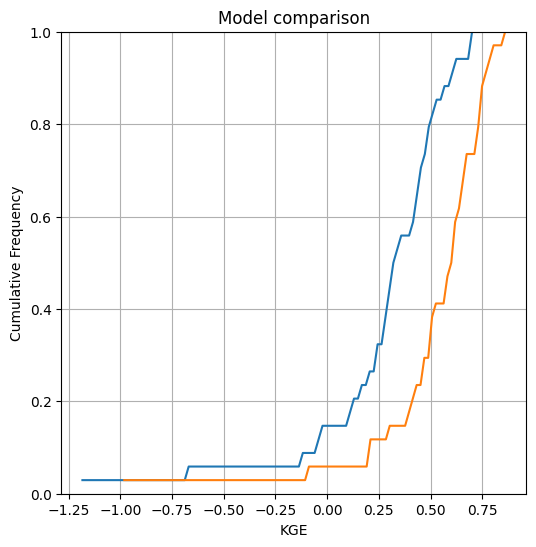

In [453]:
model_name

NameError: name 'model_name' is not defined

In [469]:

swmm_corrected

,discharge(cms)
,HY017
2016-08-07 09:00:00,0.136687
2016-08-07 10:00:00,0.129877
2016-08-07 11:00:00,0.125464
2016-08-07 12:00:00,0.123002
2016-08-07 13:00:00,0.121408
...,...
2017-07-09 05:00:00,0.402239
2017-07-09 06:00:00,0.393921
2017-07-09 07:00:00,0.435566


In [476]:
x

array([-0.98035822, -0.96176227, -0.94316631, -0.92457035, -0.9059744 ,
       -0.88737844, -0.86878249, -0.85018653, -0.83159057, -0.81299462,
       -0.79439866, -0.7758027 , -0.75720675, -0.73861079, -0.72001484,
       -0.70141888, -0.68282292, -0.66422697, -0.64563101, -0.62703506,
       -0.6084391 , -0.58984314, -0.57124719, -0.55265123, -0.53405527,
       -0.51545932, -0.49686336, -0.47826741, -0.45967145, -0.44107549,
       -0.42247954, -0.40388358, -0.38528763, -0.36669167, -0.34809571,
       -0.32949976, -0.3109038 , -0.29230784, -0.27371189, -0.25511593,
       -0.23651998, -0.21792402, -0.19932806, -0.18073211, -0.16213615,
       -0.1435402 , -0.12494424, -0.10634828, -0.08775233, -0.06915637,
       -0.05056041, -0.03196446, -0.0133685 ,  0.00522745,  0.02382341,
        0.04241937,  0.06101532,  0.07961128,  0.09820724,  0.11680319,
        0.13539915,  0.1539951 ,  0.17259106,  0.19118702,  0.20978297,
        0.22837893,  0.24697488,  0.26557084,  0.2841668 ,  0.30

0.5224724535562142

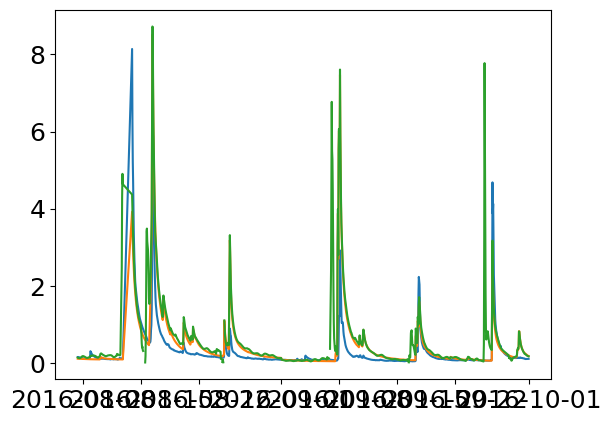

In [474]:

june_july_filter = obs.loc["2016-08-01":"2016-09-30"].index


plt.plot(obs.loc[june_july_filter,:], label="Observed")
plt.plot(swmm_uncorrected.loc[june_july_filter,:], label="Uncorrected")
plt.plot(swmm_corrected.loc[june_july_filter,:], label="Corrected")

Performance(obs, swmm_uncorrected).kge()
Performance(obs, swmm_corrected).kge()



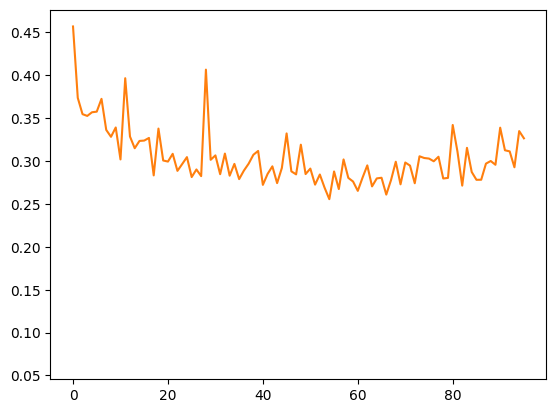

In [258]:
plt.plot(train_loss)
plt.plot(val_loss)

In [436]:
model

<Sequential name=sequential_129, built=True>

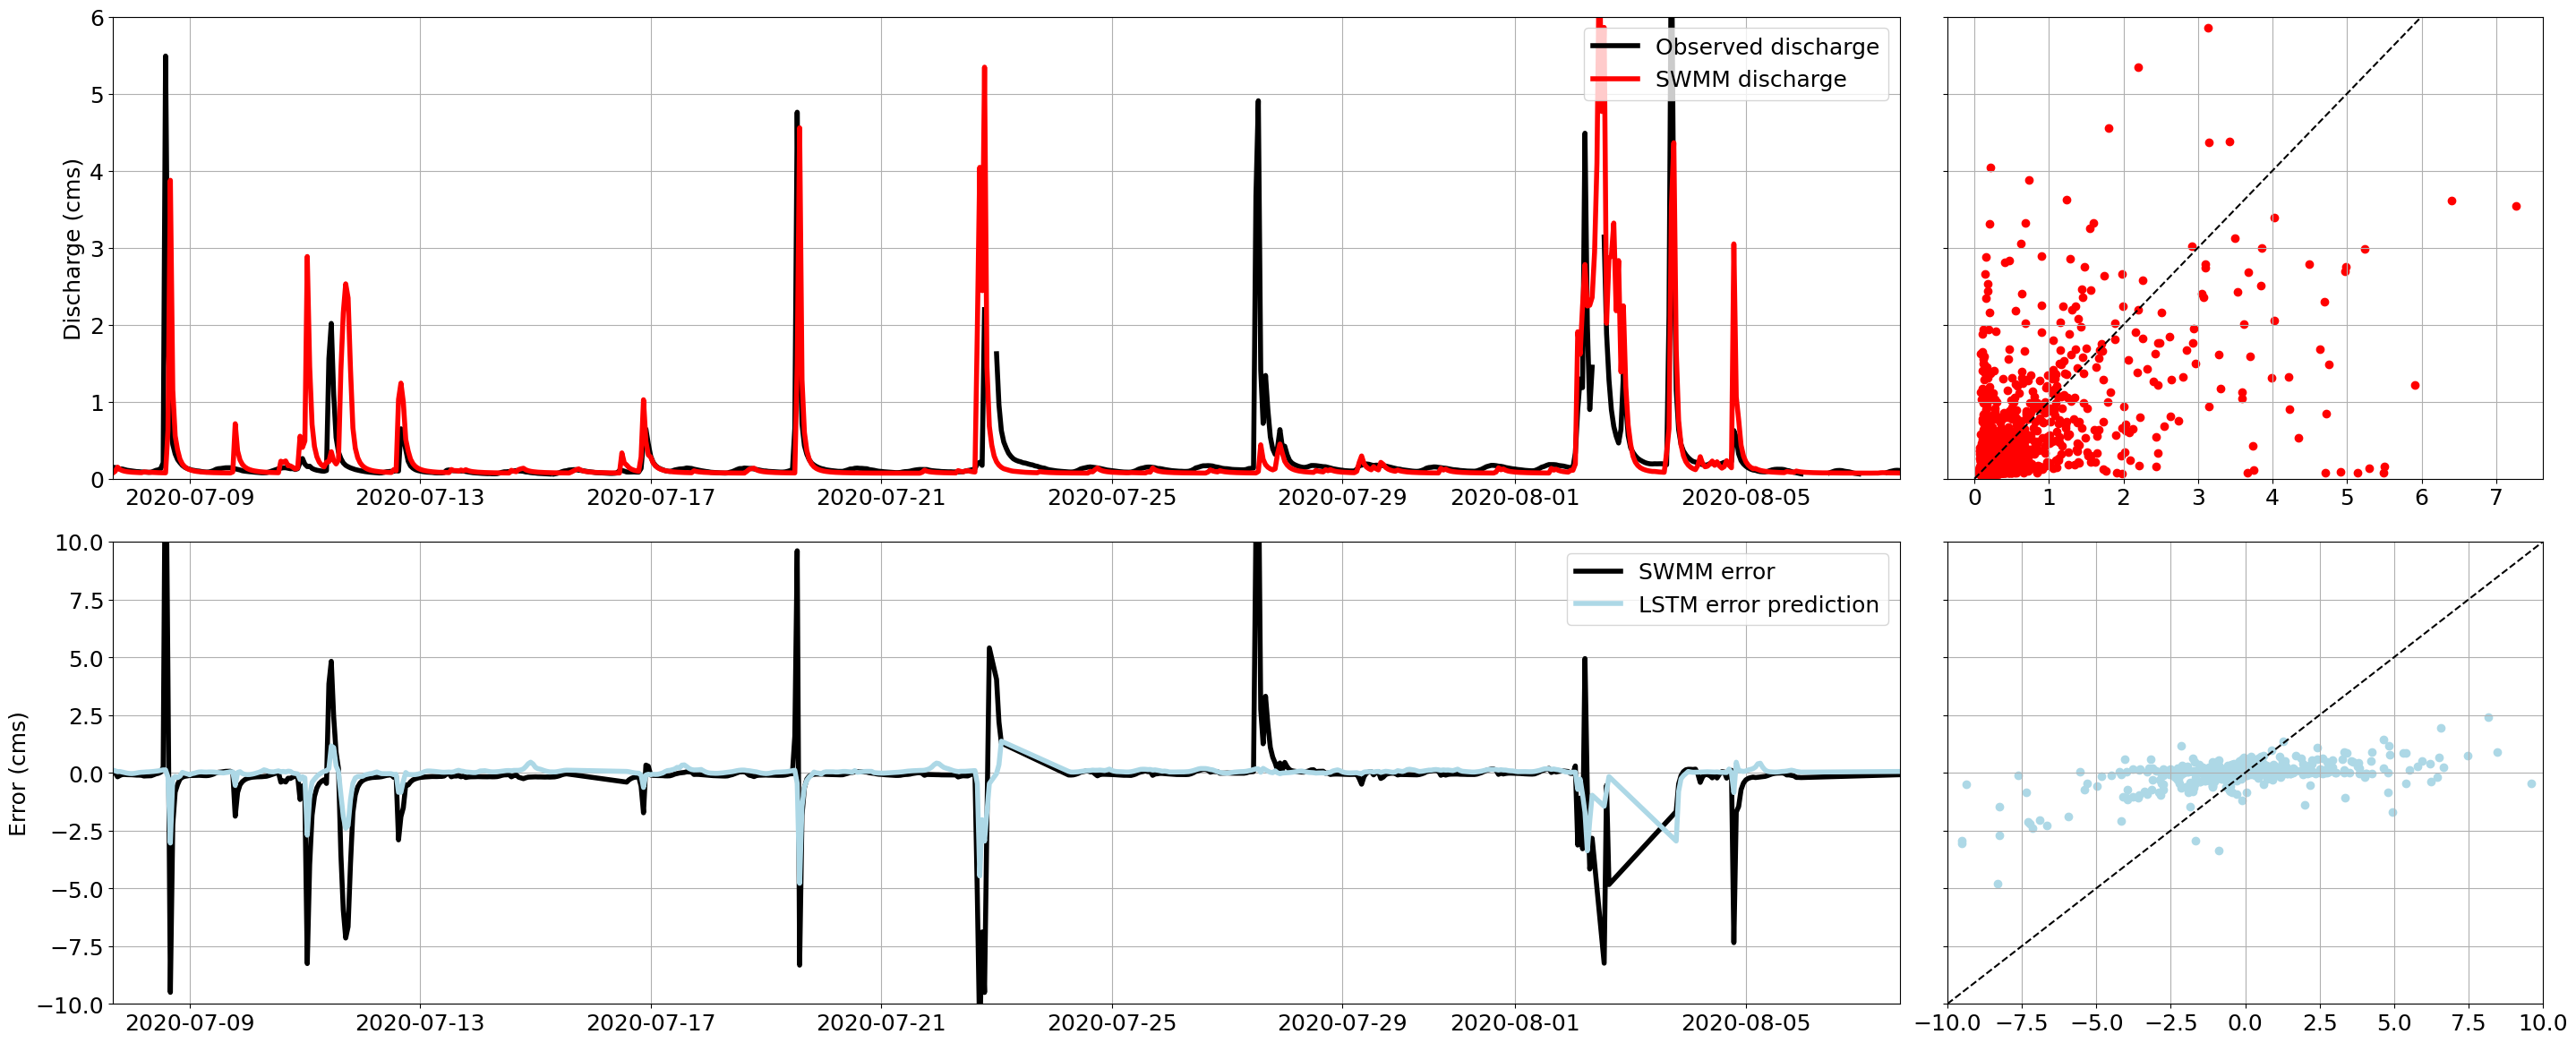

In [435]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(29, 12), gridspec_kw={'width_ratios': [3, 1]}, sharey='row')
ax[0, 0].plot(swmm_target, label="Observed discharge", color="black", linewidth=4)
ax[0, 0].plot(swmm, label="SWMM discharge", color="red", linewidth=4)


ax[0,1].scatter(swmm_target, swmm, label="1:1", color="red",marker='o')
ax[0,1].plot([0, 6], [0, 6], color="black", linestyle="--")


ax[0, 0].set_ylabel("Discharge (cms)")
ax[0,0].set_ylim([0, 6])

dti = swmm_target[seq_len:][valid_indices].index
ax[1,0].plot(dti, -y, label="SWMM error", color="black", linewidth=4)

ax[1,0].plot(dti, -y_pred, label="LSTM error prediction", color="lightblue", linewidth=4)

ax[1,0].set_ylabel("Error (cms)")

ax[1,1].scatter(-y, -y_pred, label="1:1", color="lightblue",marker='o')
ax[1,1].plot([-10, 10], [-10, 10], color="black", linestyle="--")
ax[1,1].set_xlim([-10, 10])
ax[1,1].set_ylim([-10, 10])


ax[0,0].set_xlim([swmm_target.index.min() + pd.DateOffset(months=4), swmm_target.index.min() + pd.DateOffset(months=5)])
ax[1, 0].set_xlim(ax[0, 0].get_xlim())
ax[0,0].legend(loc="upper right")
ax[1,0].legend(loc="upper right")

fig.tight_layout()
for axes in ax.flat:
    axes.grid(True)

output_path = Path(r"G:\My Drive\02_phd\00_conferences\2025-05 EGU\figs")
fig.savefig(output_path / "swmm_correction.png", dpi=500)

In [370]:
len(target)

8182

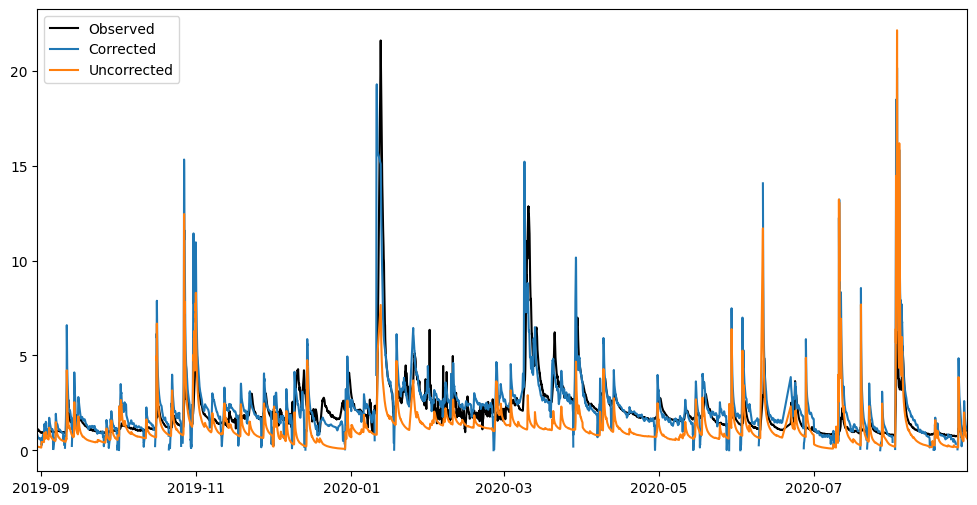

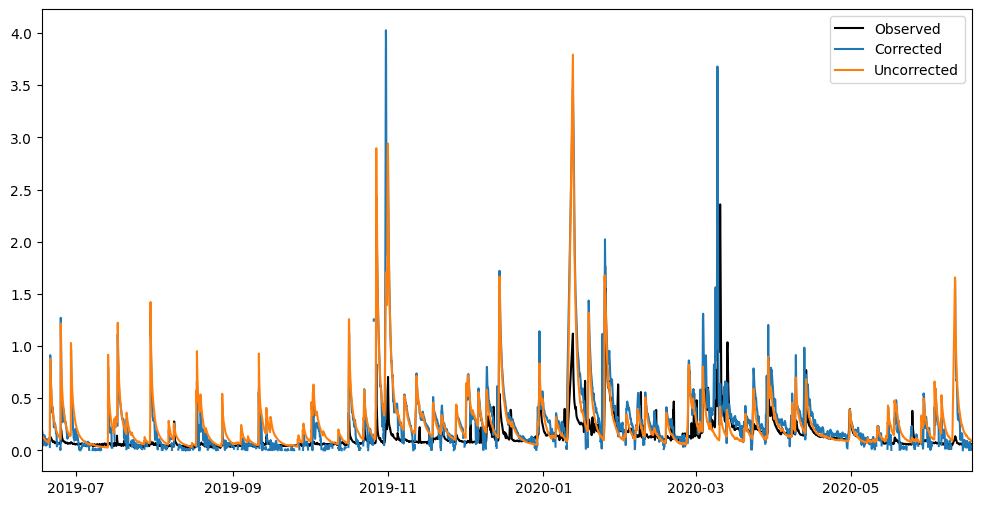

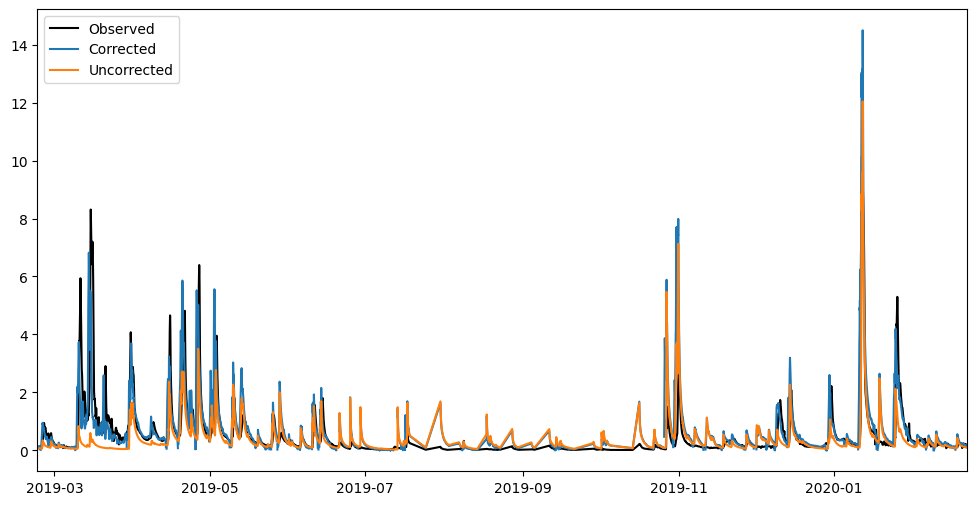

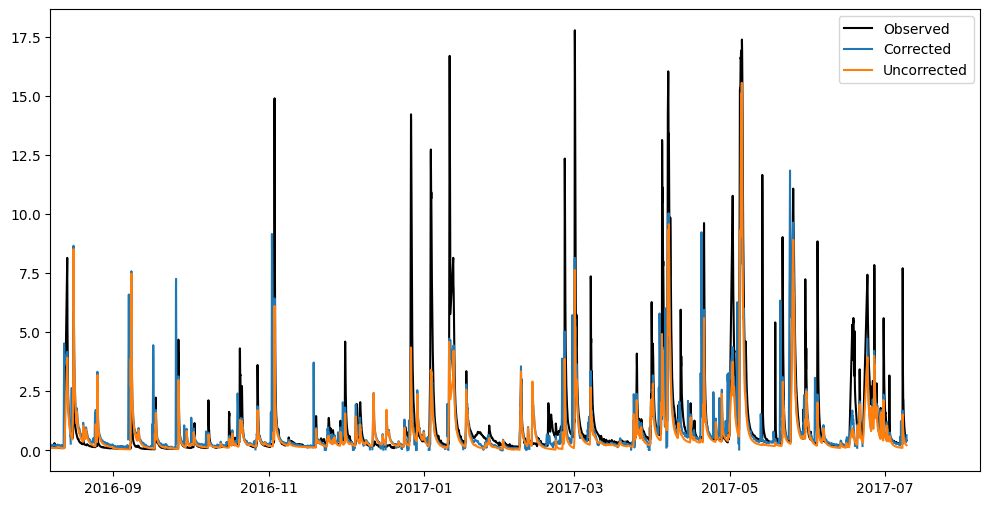

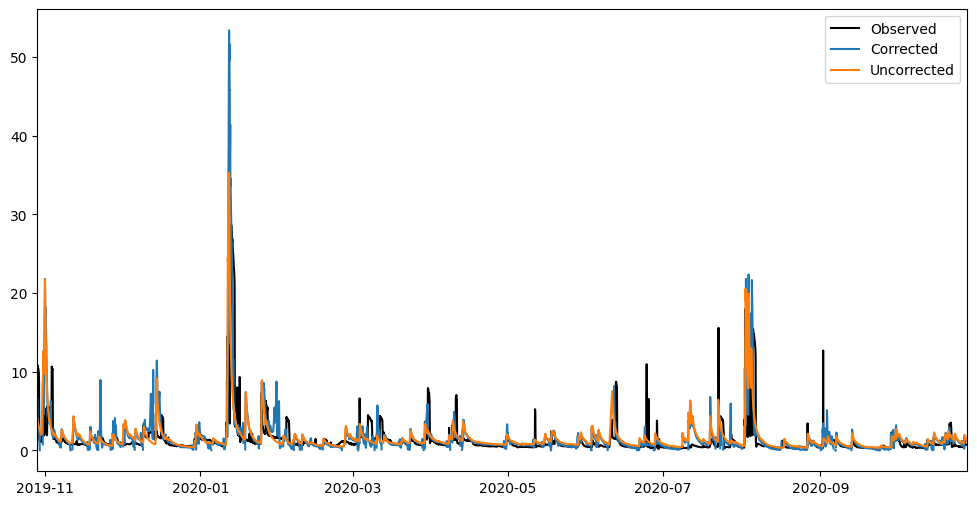

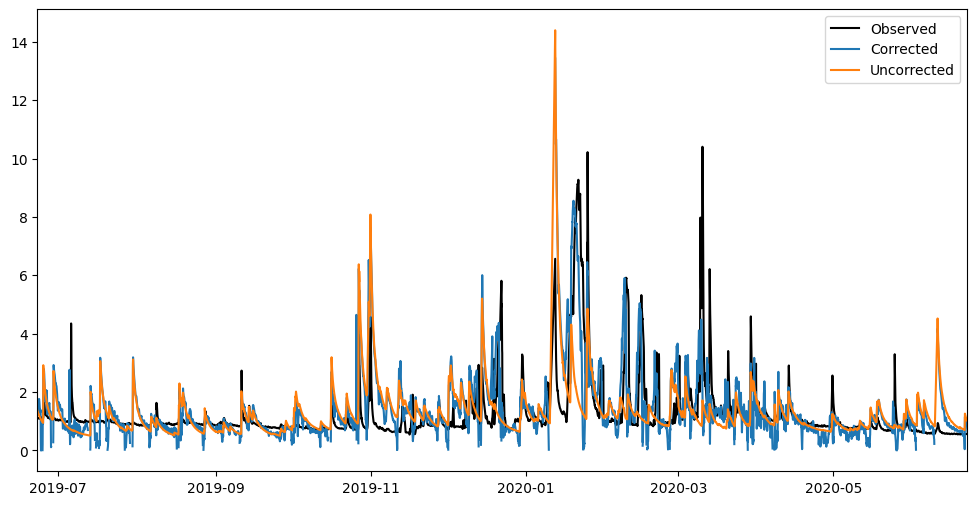

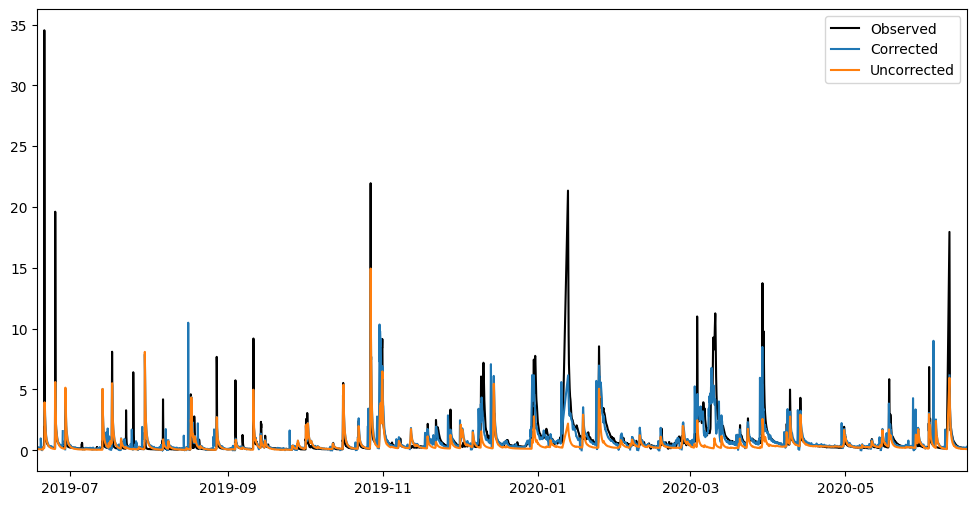

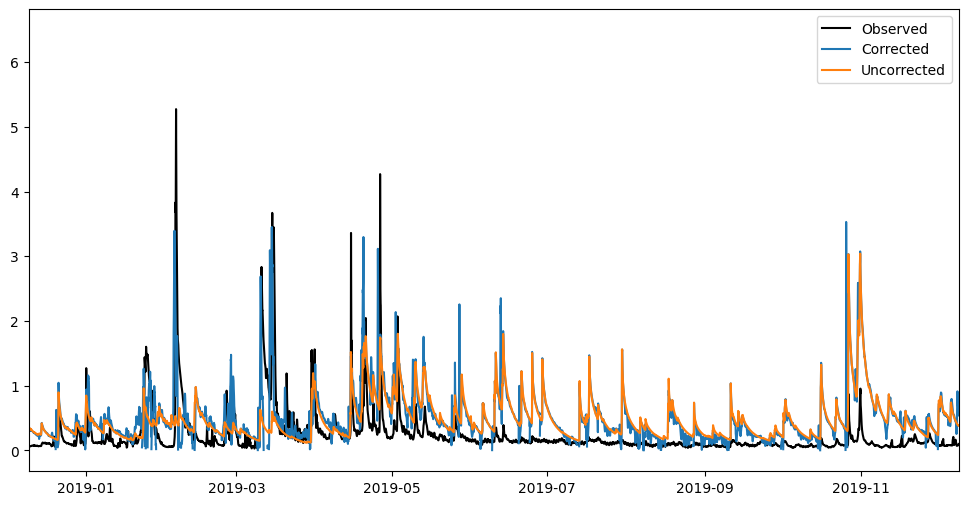

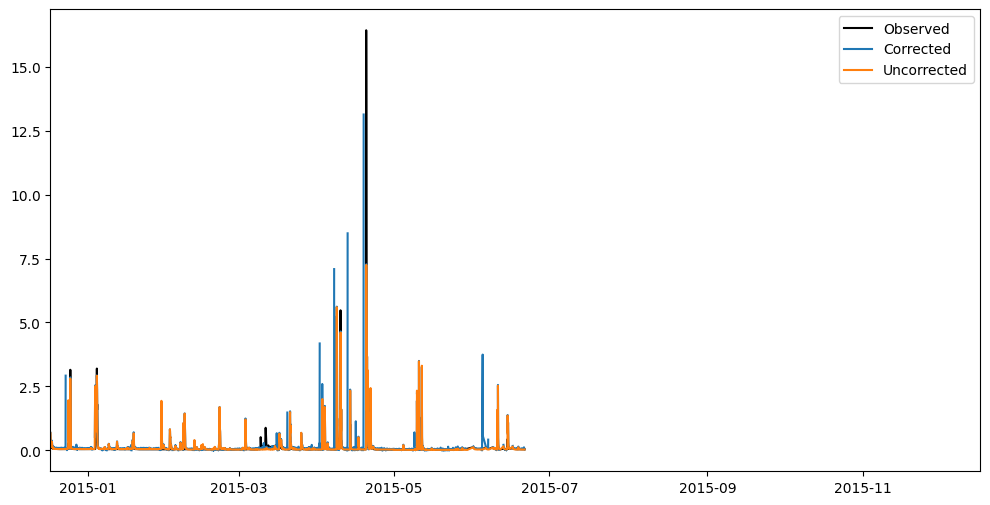

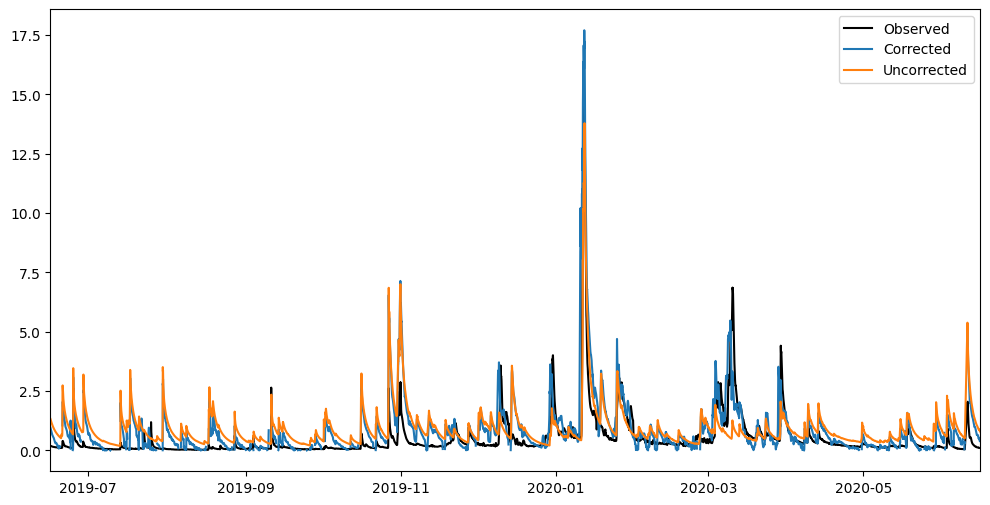

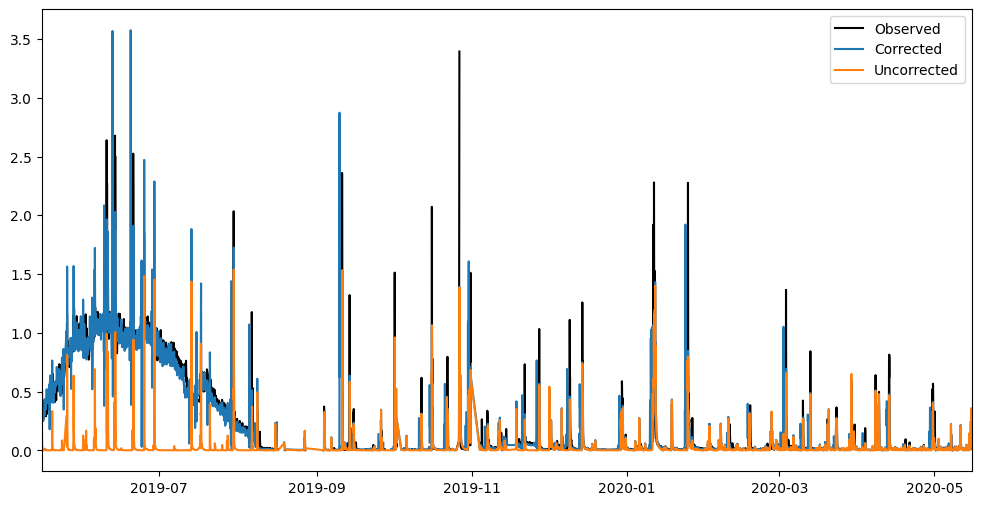

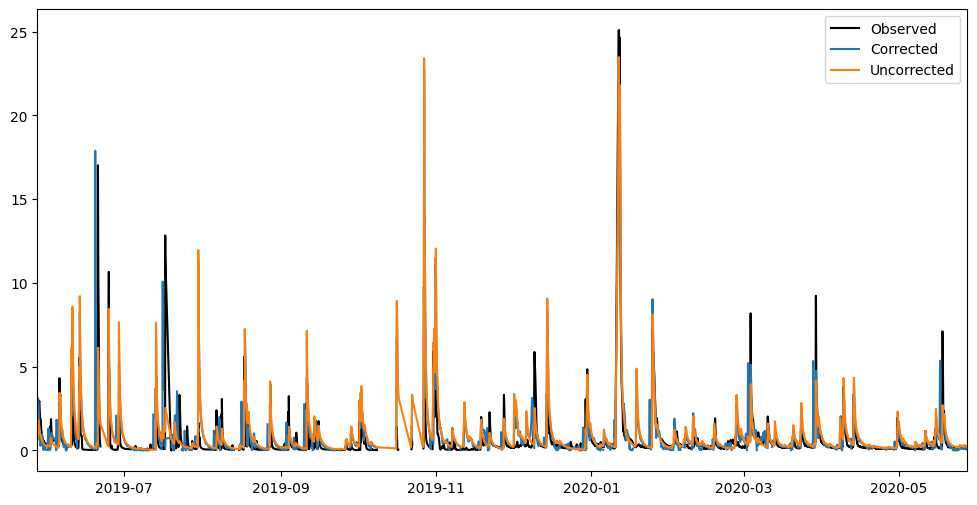

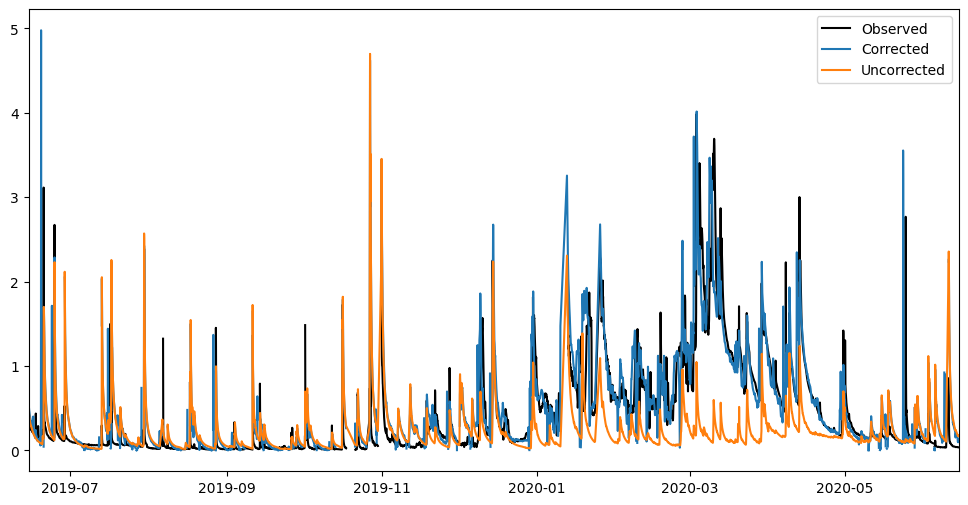

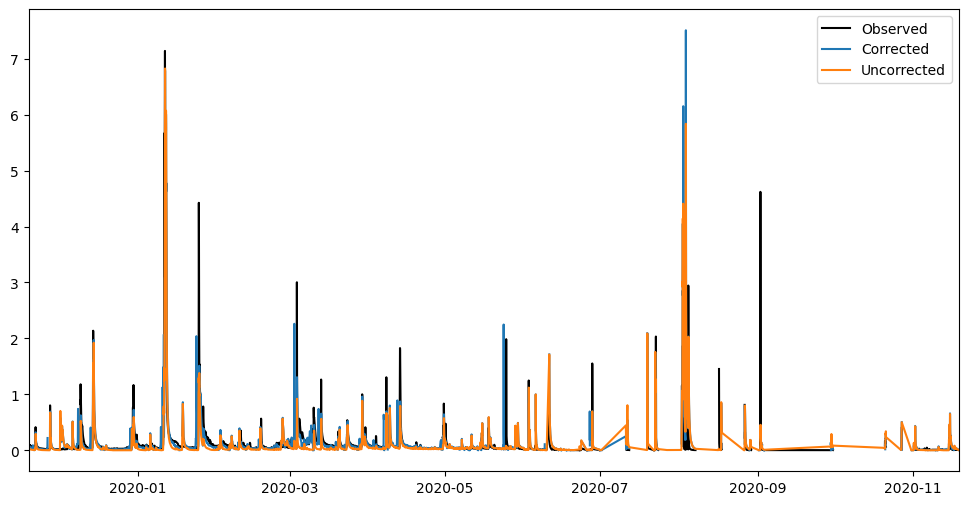

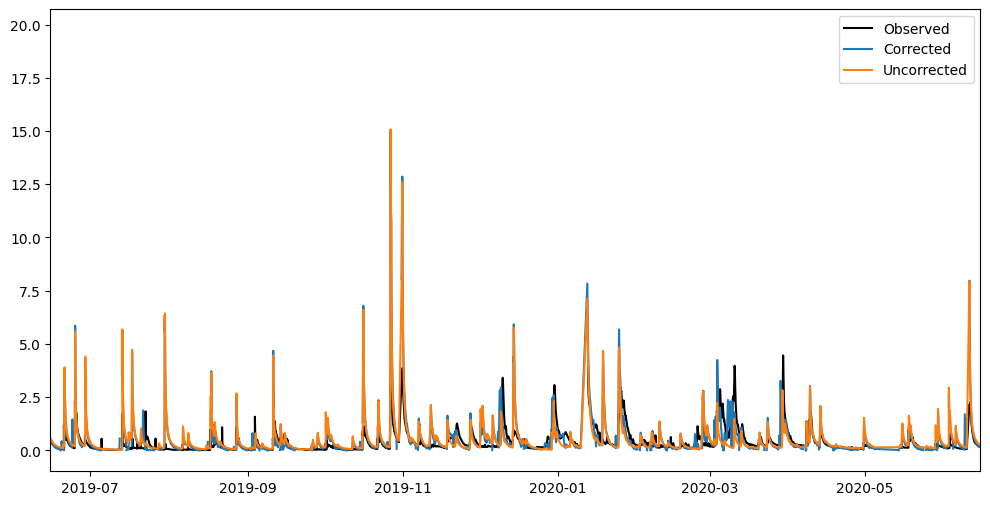

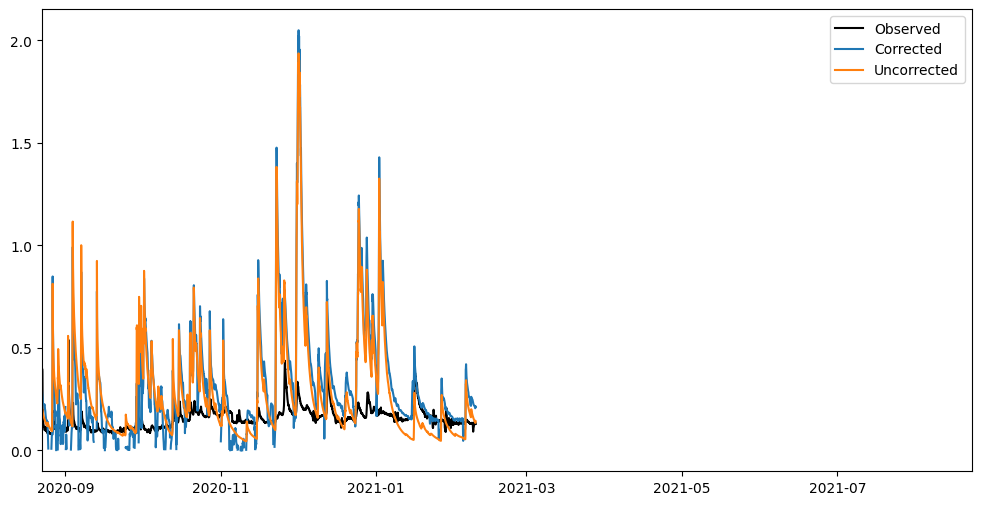

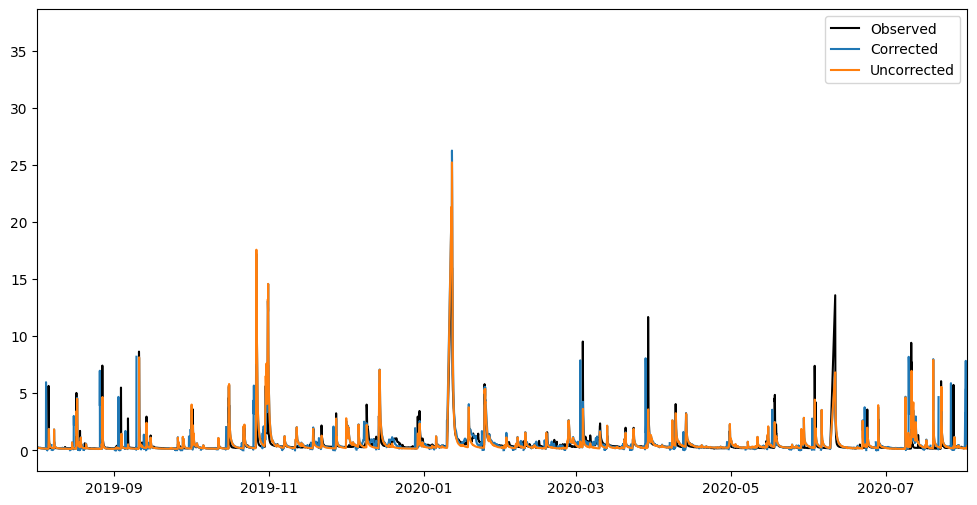

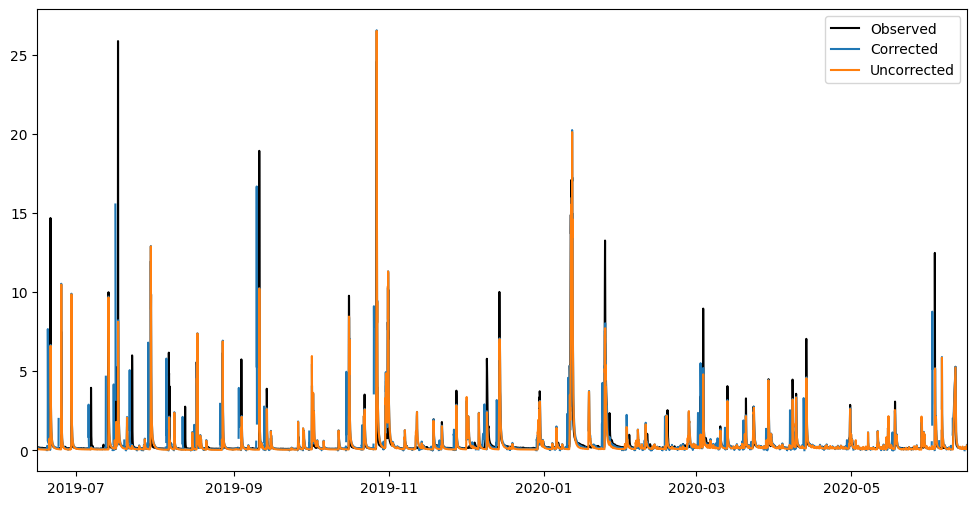

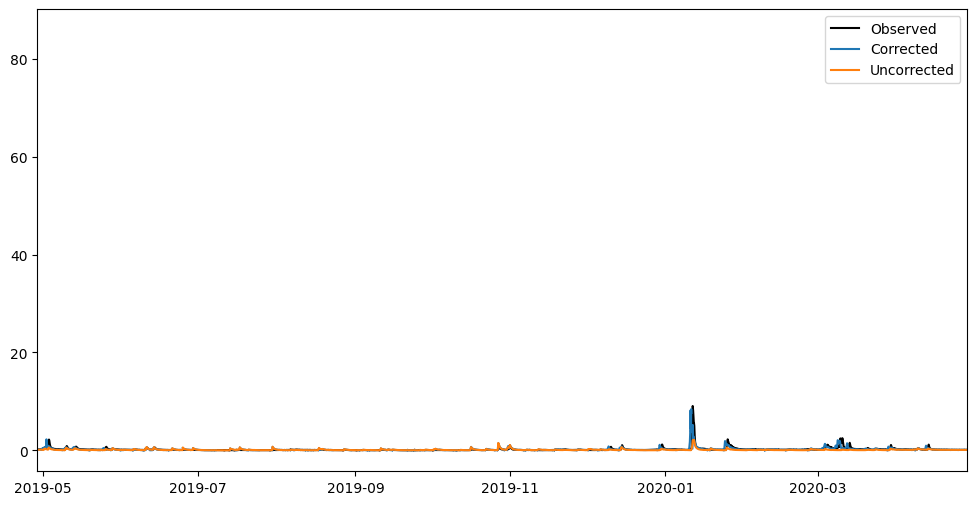

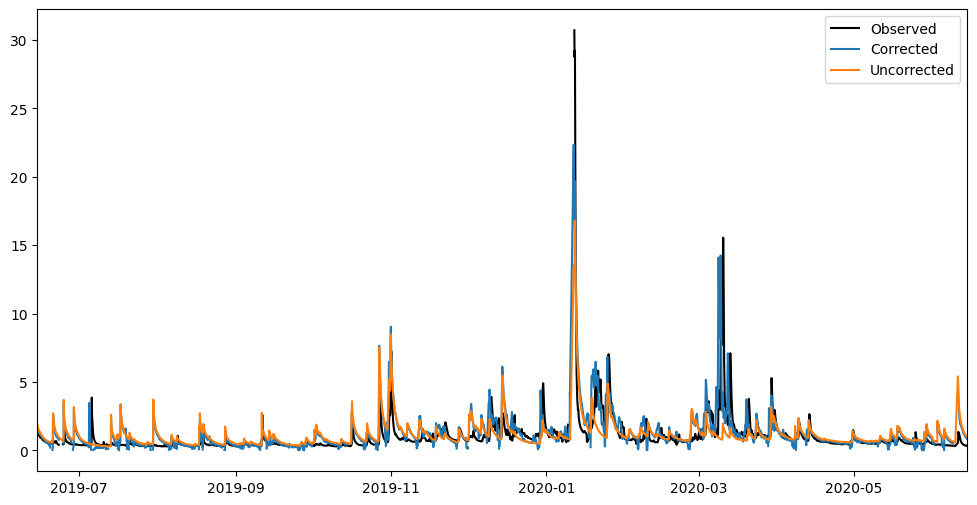

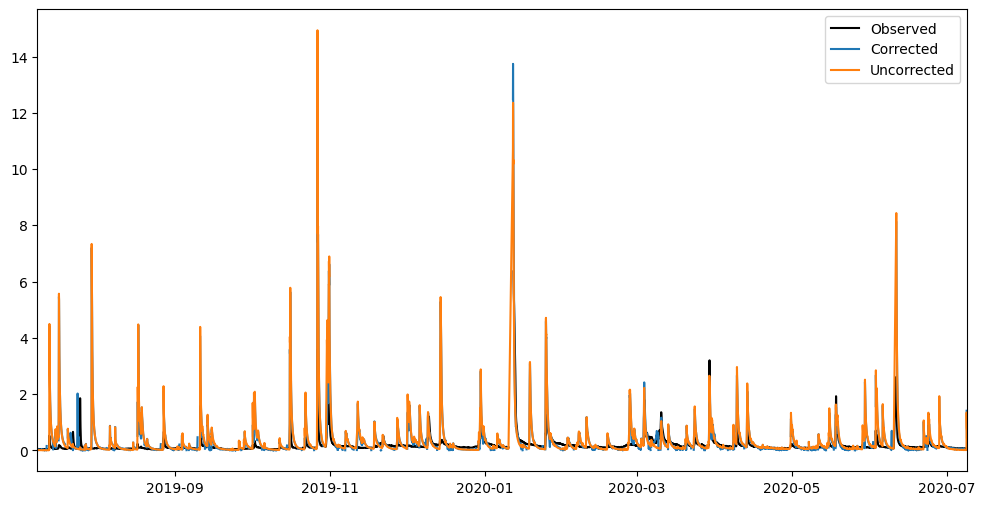

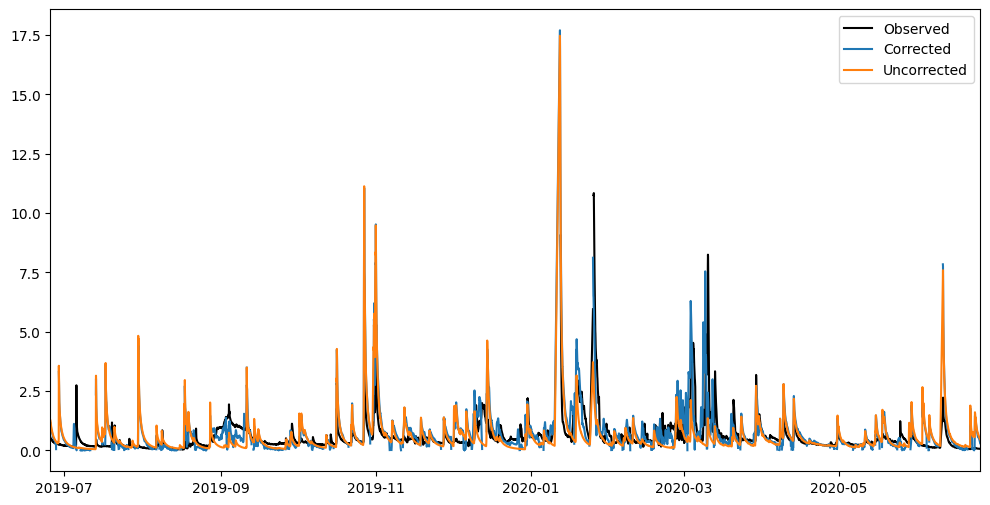

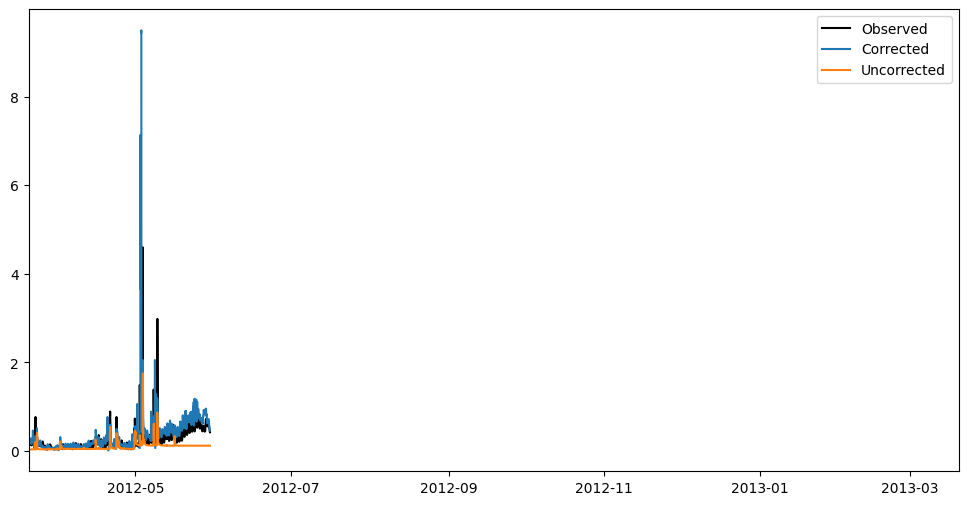

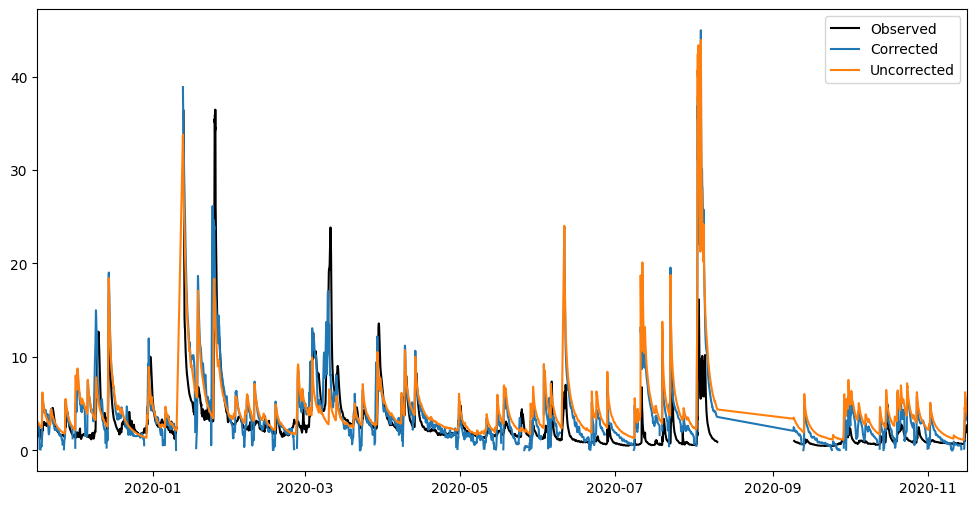

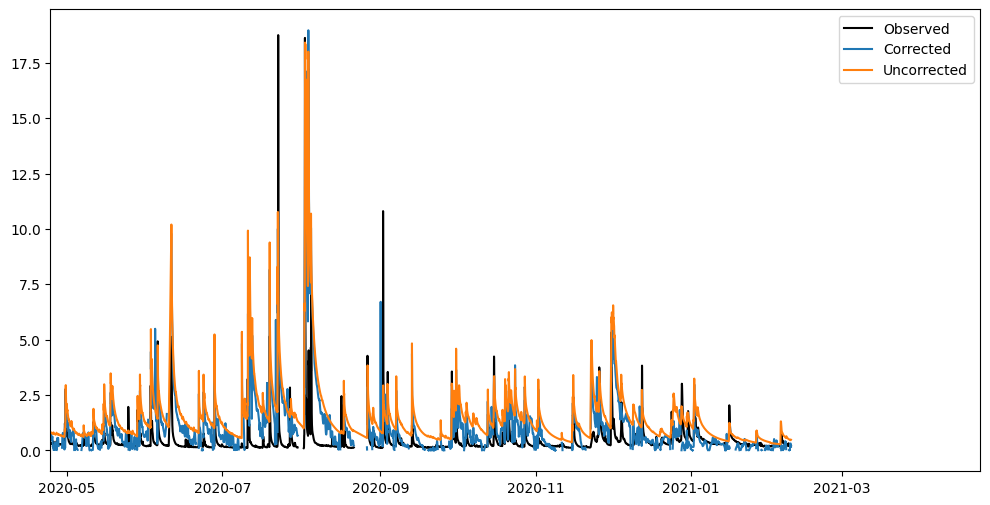

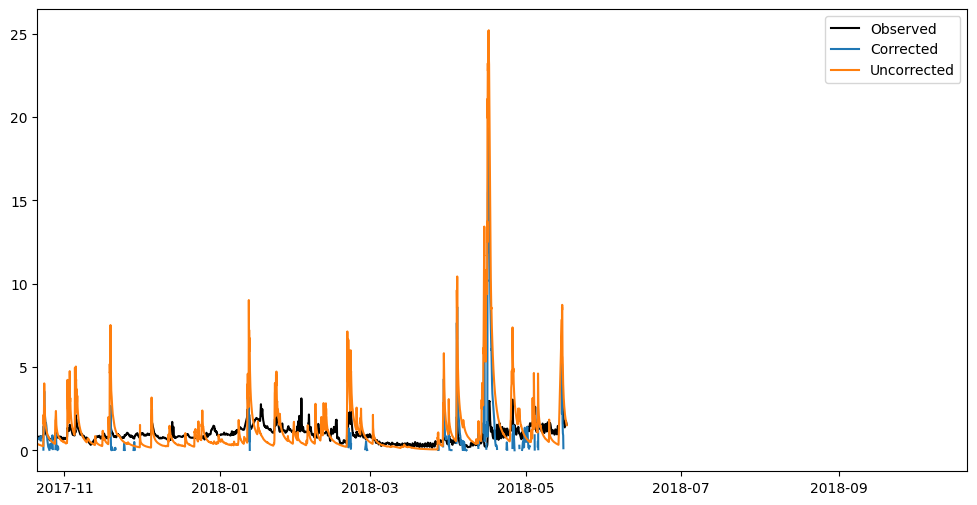

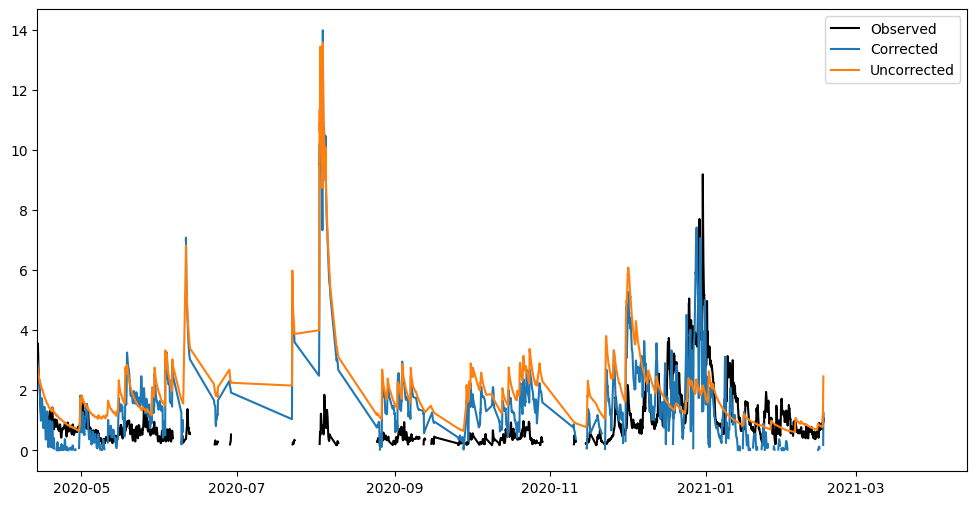

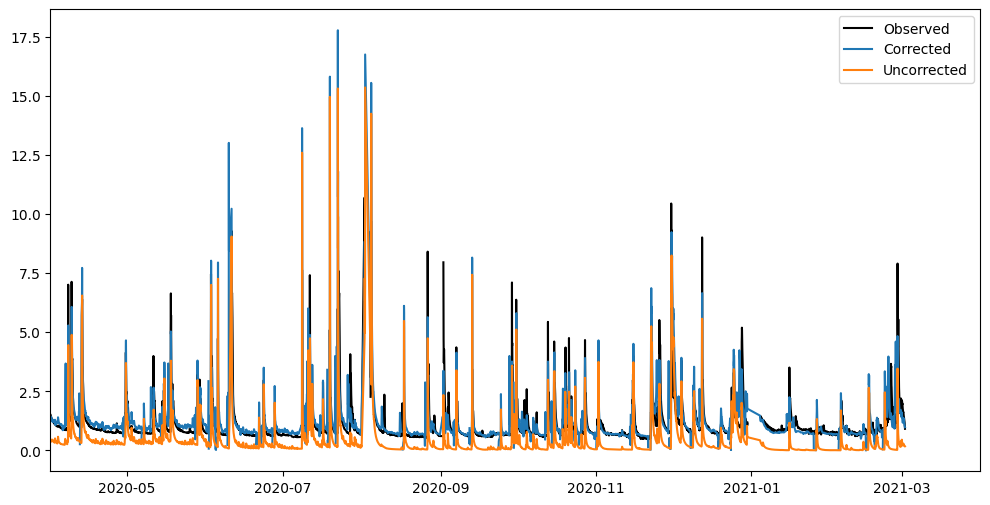

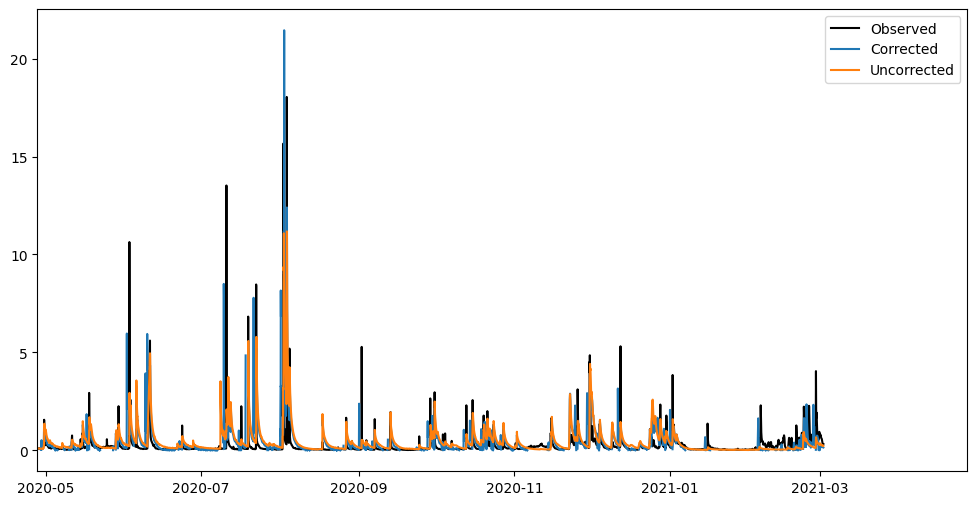

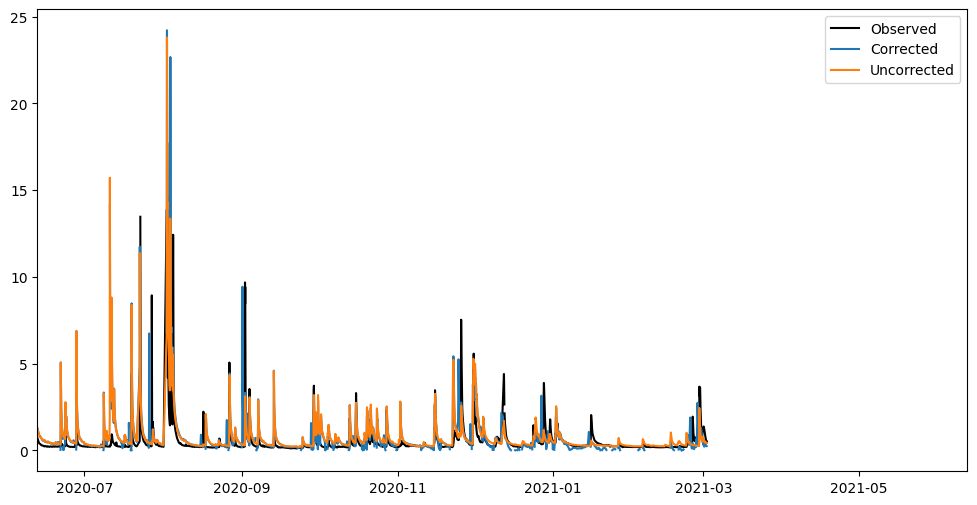

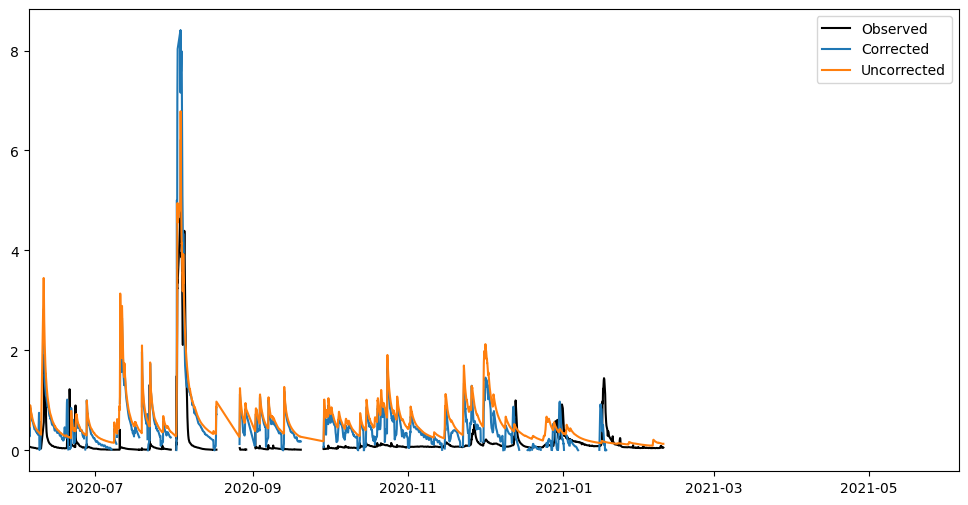

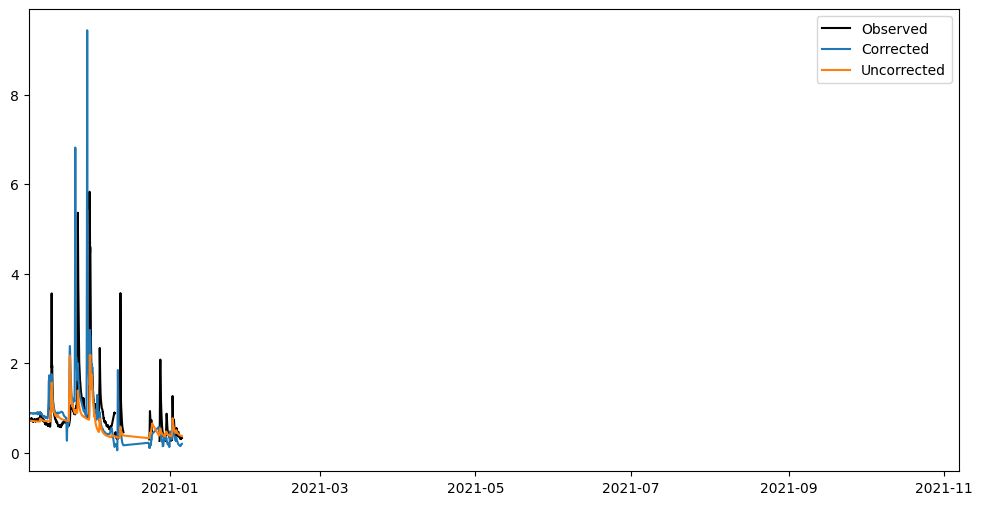

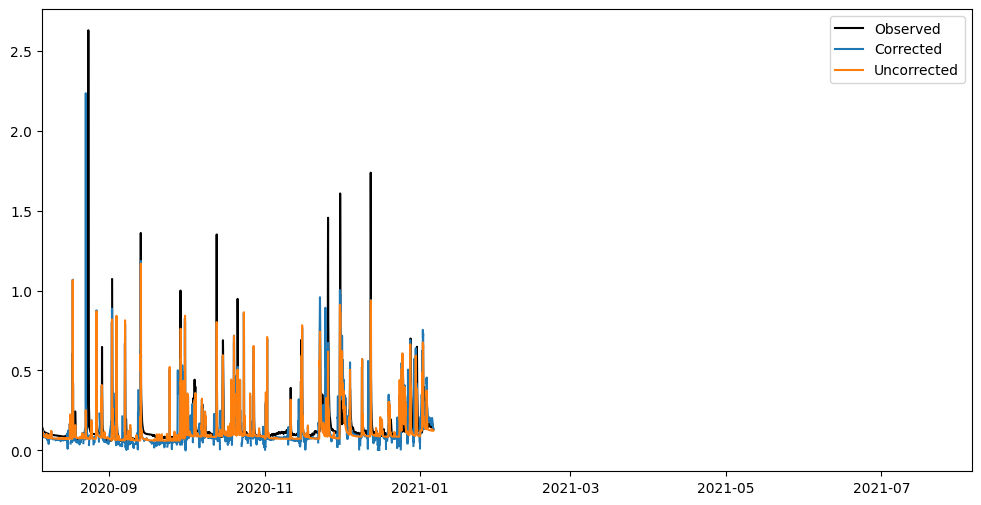

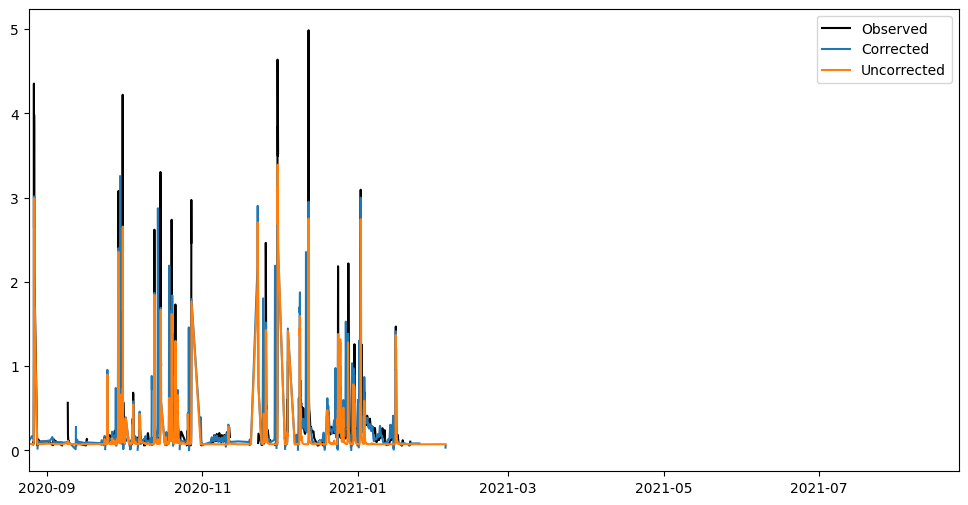

In [217]:
for model in base_dir.iterdir():
    if not (model / "timeseries_corrected.csv").exists():
        continue
    merged = pd.read_csv(model / "timeseries_corrected.csv", index_col=0, parse_dates=True, header=[0,2])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(merged.index, merged["Observed"], label="Observed", color="black")

    ax.plot(merged.index, merged["Corrected"], label="Corrected")
    ax.plot(merged.index, merged["Uncorrected"], label="Uncorrected")

    ax.set_xlim([merged.index.min(), merged.index.min() + pd.DateOffset(years=1)])
    ax.legend()
    plt.show()

,Corrected,Uncorrected,Observed
NaT,discharge(cms),discharge(cms),discharge(cms)
NaT,HY006,HY006,HY006
2019-08-26 16:00:00,NaN,0.1404692381620407,0.8948966909897261
2019-08-26 17:00:00,NaN,0.1394706517457962,0.8976612469397679
2019-08-26 18:00:00,NaN,0.13848693668842316,0.8935566162241307
...,...,...,...
2021-03-02 03:00:00,2.0162783336819374,1.1423697471618652,1.8447732007285216
2021-03-02 04:00:00,2.0881608490328913,1.139327049255371,1.7921197962351259
2021-03-02 05:00:00,2.165972458902138,1.136380910873413,1.7031472299645283
2021-03-02 06:00:00,2.2489669687404503,1.1335257291793823,1.6237083729998394


0.5994743608044738

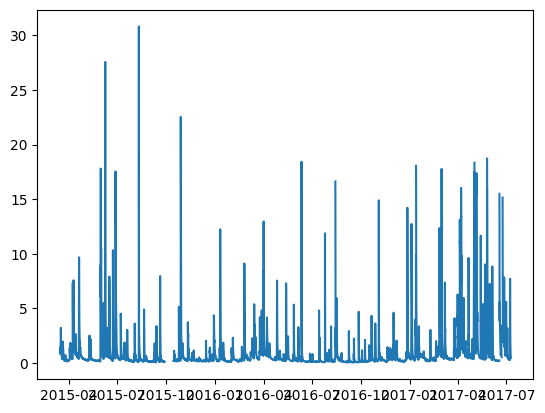

In [93]:
plt.plot(swmm_target[:-24][valid_indices])